Stone Soup 06 - Accumulated State Densities Kalman
====================

In [24]:
# Some general imports and set up
import matplotlib
%matplotlib inline

from datetime import timedelta
from datetime import datetime

import numpy as np

Simulate data
--------------
To start we'll create a simple truth path, with position at 1 second interval. This will represent an object moving constantly in both $x$ and $y$.

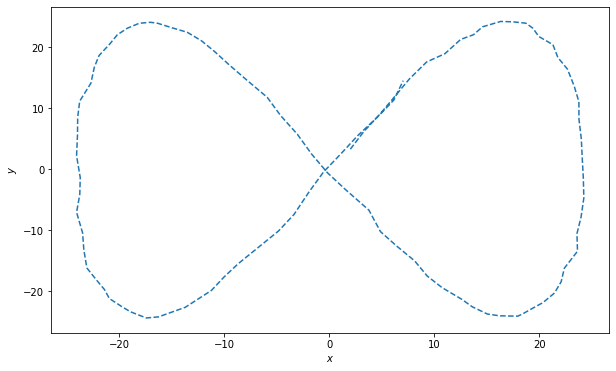

In [25]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

# Figure to plot truth (and future data)
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

# Lissajous curve
acceleration = 7
omega = 8 / (2*60)
velocity=13
# position matrix, matrix_a
matrix_a = velocity ** 2 / acceleration

truth = GroundTruthPath()
start_time = datetime.now()
for n in range(1, 100):
    x = matrix_a * np.sin(omega * n)
    y = matrix_a * np.sin(omega * 2 * n)
    varxy = np.array([[0.05,0],[0,0.05]])
    xy = np.random.multivariate_normal(np.array([x,y]),varxy)
    truth.append(GroundTruthState(np.array([[xy[0]], [xy[1]]]), timestamp=start_time + timedelta(seconds=n)))

#Plot the result
ax.plot([state.state_vector[0, 0] for state in truth], 
        [state.state_vector[1, 0] for state in truth], 
        linestyle="--")

Now we have a straight line path, we'll simulate our measurements of this, using normal distribution with mean of the true position, with a covariance of 0.25.

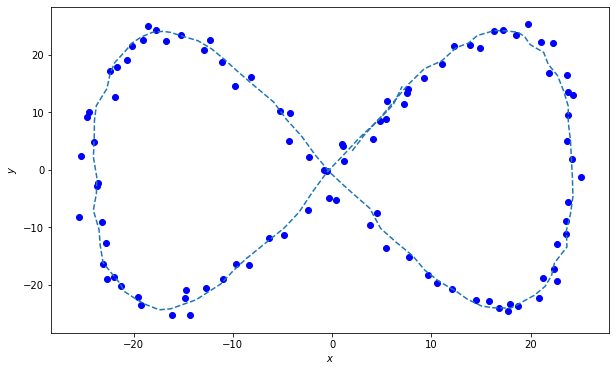

In [26]:
from scipy.stats import multivariate_normal

from stonesoup.types.detection import Detection

measurements = []
for state in truth:
    x, y = multivariate_normal.rvs(
        state.state_vector.ravel(), cov=np.diag([0.75, 0.75]))
    measurements.append(Detection(
        np.array([[x], [y]]), timestamp=state.timestamp))
    
# Plot the result
ax.scatter([state.state_vector[0, 0] for state in measurements], 
           [state.state_vector[1, 0] for state in measurements], 
           color='b')
fig

Create Models and Kalman Filter
---------------------------------
Now we have our measurements, which you can see against the true path in the plot above, we'll begin creating our Kalman Filter.

First we'll create a transition model that describes how that object's state changes over time, in this case constant velocity. As we are working in two dimensions, we'll combine two 1D constant velocity models, giving us a state of $[x, \dot{x}, y, \dot{y}]$. Both dimensions have a noice coeffiecent of 0.1.

In [27]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(0.05), ConstantVelocity(0.05)))

This model gives us our transition matrix $F$ (shown here for period 1 second)

In [28]:
transition_model.matrix(time_interval=timedelta(seconds=1))

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

And the process noise covariance $Q$ (shown here for period of 1 second)

In [29]:
transition_model.covar(time_interval=timedelta(seconds=1))

array([[0.01666667, 0.025     , 0.        , 0.        ],
       [0.025     , 0.05      , 0.        , 0.        ],
       [0.        , 0.        , 0.01666667, 0.025     ],
       [0.        , 0.        , 0.025     , 0.05      ]])

With this model, we can now build a Accumulated State Density Kalman Predictor object, which we'll use to predict the state $x_{k|k-1}$

In [30]:
from stonesoup.predictor.kalman import ASDKalmanPredictor
predictor = ASDKalmanPredictor(transition_model)

Next we'll create our model which will describe errors of measuring in the observable state, and how the hidden state maps to observable state. In this case we can simply map the $x$ and $y$ directly.

In [31]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    4, # Number of state dimensions (position and velocity in 2D)
    (0,2), # Mapping measurement vector index to state index
    np.array([[0.75, 0],  # Covariance matrix for Gaussian PDF
              [0, 0.75]])
    )

This will give us the observation model $H$.

In [32]:
measurement_model.matrix()

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]])

And observation model covariance $R$.

In [33]:
measurement_model.covar()

array([[0.75, 0.  ],
       [0.  , 0.75]])

With this model, we can now build a Accumulated State Density Kalman Updater object, which we'll use to update our estimate with an measurement, giving us $x_{k|k}$

In [34]:
from stonesoup.updater.kalman import ASDKalmanUpdater
updater = ASDKalmanUpdater(measurement_model)

Running the Kalman Filter
--------------------------
Now we have the components, we can run our simulated data through the Kalman Filter.

To start, we'll need to create a prior estimaite of where we think our target will be.

In [35]:
from stonesoup.types.state import ASDGaussianState
start_time= datetime.now()
prior = ASDGaussianState(multi_state_vector=[[0], [1], [0], [1]],timestamps=start_time, multi_covar=np.diag([1.5, 0.5, 1.5, 0.5]), max_nstep=120)

With this, we'll now loop through our measurements, predicting and updating at each timestep.

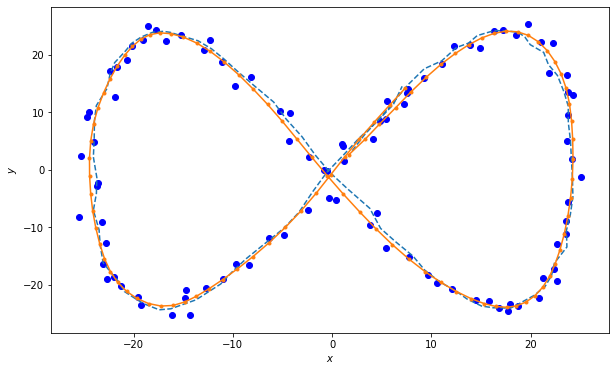

In [36]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement) # Used to group a prediction and measurement together
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

# Plot the resulting track
states = track[-1].state_list

ax.plot([state.state_vector[0, 0] for state in states], 
        [state.state_vector[2, 0] for state in states],
        marker=".")
fig

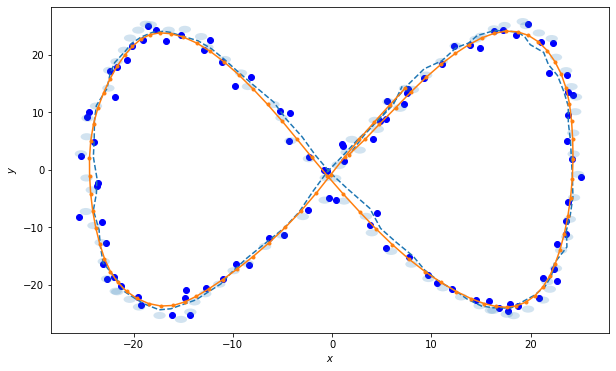

In [37]:
from matplotlib.patches import Ellipse
states = track[-1].state_list
for state in track:
    w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
    max_ind = np.argmax(v[0, :])
    orient = np.arctan2(v[max_ind, 1], v[max_ind, 0])
    ellipse = Ellipse(xy=state.state_vector[(0,2), 0],
                      width=np.sqrt(w[0])*2, height=np.sqrt(w[1])*2,
                      angle=np.rad2deg(orient),
                      alpha=0.2)
    ax.add_artist(ellipse)
states
fig